# Object-Oriented Programming: A Primer for Reinforcement Learning
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eleni-vasilaki/rl-notes/blob/main/notebooks/00_oop_primer.ipynb)

This primer introduces the object-oriented programming (OOP) techniques used throughout the reinforcement learning notebooks. The goal is not to present OOP as a set of templates to copy, but to develop the intuition for *when* and *why* these techniques help — and to prepare you for libraries like PyTorch, which are built on exactly the same ideas.

## 1. Finding Classes in Your Problem

Before writing any code, read the problem description carefully. A useful rule of thumb:

> **Nouns suggest classes. Verbs suggest methods.**

Consider this sentence from a reinforcement learning textbook:

> *"An **agent** **selects** an **action** in an **environment**. The **environment** **returns** a **reward** and **transitions** to a new **state**."*

The nouns — *agent*, *environment* — are things with identity. They persist over time, they have properties (the agent has a policy; the environment has a layout), and they do things (the agent selects; the environment transitions). These are natural candidates for classes.

Other nouns — action, reward, state — are usually simple values (int, float, tuple), so a plain number or array will do. Occasionally a state needs a richer structure, and then modeling it as a class makes sense.

This distinction matters because it tells you where to invest your effort. A class is worth writing when something has **state that changes over time** and **operations that act on that state**. If something is just a value passed around, keep it simple.

## 2. The Key Question: "What Needs to Remember?"

The single most useful question when deciding whether to use a class is:

> **Does this thing need to remember something between one call and the next?**

An environment remembers the agent's position. An agent remembers its Q-values. A policy remembers its estimates of how good each action is. These all have *state* — data that persists and changes — so they benefit from being classes.

A sigmoid function, on the other hand, just transforms an input and returns an output. It doesn't remember anything. It should be a plain function:

```python
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
```

Similarly, a helper that splits data into train/test sets, or one that smooths a curve, is a pure transformation — no memory, no state, just input in and output out. Keep these as standalone functions.

**Rule of thumb:** if you can describe something entirely as "given *this*, return *that*" with no hidden memory, it is a function. If it also needs to *keep track of something* across calls, it is a class.

## 3. Anatomy of a Class

A class bundles together **data** (attributes) and **behaviour** (methods) into a single unit. Here is the general structure:

```python
class ClassName:
    """One-line description of what this class represents."""

    def __init__(self, ...):       # Constructor: runs once when you create an object
        self.attribute = ...       # Instance attribute: data stored on *this* object

    def some_method(self, ...):    # Method: a function that can read/modify the object's data
        ...
```

Three things to notice:

- **`__init__`** is the constructor. It runs automatically when you write `ClassName(...)`. Its job is to set up the object's initial state.
- **`self`** is how each object refers to itself. When you write `self.Q = np.zeros(k)`, you are storing an array *on this particular object*, not in some global variable. Two objects created from the same class have independent copies of their attributes.
- **Methods** are functions defined inside the class. They always receive `self` as their first argument, giving them access to the object's data.

Let us make this concrete with a simple example from reinforcement learning: a single arm of a multi-armed bandit.

In [4]:
import numpy as np


class BanditArm:
    """A single arm of a multi-armed bandit."""

    def __init__(self, true_mean):
        """
        Args:
            true_mean (float): The true expected reward of this arm.
        """
        self.true_mean = true_mean   # Stored on the object — this is state
        self.pull_count = 0          # Also property of the state: tracks how often we pulled

    def pull(self):
        """Sample a reward (Gaussian noise around the true mean)."""
        self.pull_count += 1         # Modifying the object's own state
        return self.true_mean + np.random.randn()


# Create two independent arm objects from the same blueprint
arm_a = BanditArm(true_mean=1.0)
arm_b = BanditArm(true_mean=3.0)

# Each object tracks its own state independently
print(f"Pull arm A: reward = {arm_a.pull():.2f}  (pulled {arm_a.pull_count} time)")
print(f"Pull arm B: reward = {arm_b.pull():.2f}  (pulled {arm_b.pull_count} time)")
print(f"Pull arm A again: reward = {arm_a.pull():.2f}  (pulled {arm_a.pull_count} times)")
print(f"Arm B is unaffected: pulled {arm_b.pull_count} time")

Pull arm A: reward = 0.81  (pulled 1 time)
Pull arm B: reward = 3.21  (pulled 1 time)
Pull arm A again: reward = 1.63  (pulled 2 times)
Arm B is unaffected: pulled 1 time


Notice that pulling `arm_a` twice does not affect `arm_b` at all. Each object is its own independent bundle of data. This is **encapsulation**: the arm's internal bookkeeping (its pull count, its true mean) is packaged together with the operations that use it.

## 4. A Complete Example: Environment and Agent

In reinforcement learning, the two central nouns are the **environment** and the **agent**. Let us build both for a simple problem: a one-dimensional track where the agent must walk from the left end to the right end to receive a reward.

We will write two classes and connect them through **composition** — the agent stores a reference to the environment it operates in. This keeps responsibilities separate: the environment knows the rules of the world; the agent knows the learning algorithm. Neither needs to know how the other works internally.

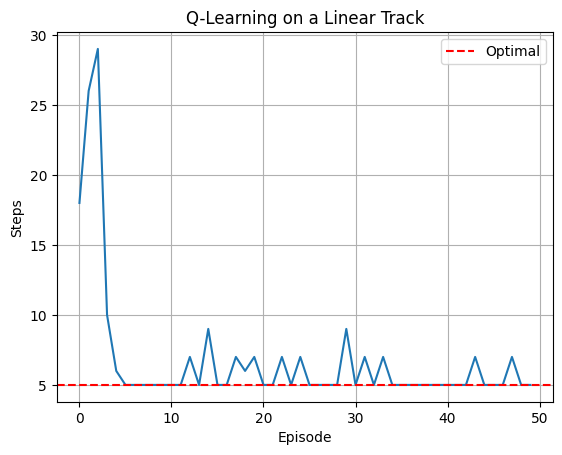

In [2]:
import numpy as np
import matplotlib.pyplot as plt


class LinearTrackEnv:
    """A one-dimensional corridor. The agent starts at state 0 and
    receives a reward of 1 upon reaching the far end."""

    def __init__(self, size):
        """
        Args:
            size (int): Number of states on the track.
        """
        self.size = size
        self.state = 0

    def reset(self):
        """Place the agent back at the start. Returns the initial state."""
        self.state = 0
        return self.state

    def step(self, action):
        """Take one step.

        Args:
            action (int): 0 = move left, 1 = move right.

        Returns:
            tuple: (next_state, reward, done)
        """
        if action == 1:
            self.state = min(self.state + 1, self.size - 1)
        else:
            self.state = max(0, self.state - 1)

        done = (self.state == self.size - 1)
        reward = 1.0 if done else 0.0
        return self.state, reward, done


class QLearningAgent:
    """Tabular Q-learning agent for discrete environments."""

    def __init__(self, env, eta=0.1, gamma=0.99, epsilon=0.1):
        """
        Args:
            env (LinearTrackEnv): The environment to learn in.
            eta (float): Learning rate.
            gamma (float): Discount factor.
            epsilon (float): Exploration probability.
        """
        self.env = env                  # Composition: the agent *has* an environment
        self.eta = eta
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((env.size, 2))  # Q-table: one row per state, two actions

    def select_action(self, state):
        """Epsilon-greedy action selection."""
        if np.random.rand() < self.epsilon:
            return np.random.randint(2)
        else:
            max_q = np.max(self.Q[state])
            best_actions = np.flatnonzero(self.Q[state] == max_q)
            return np.random.choice(best_actions)

    def update(self, state, action, reward, next_state, done):
        """Apply the Q-learning update rule."""
        target = reward if done else reward + self.gamma * np.max(self.Q[next_state])
        self.Q[state, action] += self.eta * (target - self.Q[state, action])

    def run_episode(self):
        """Execute one complete episode. Returns the number of steps taken."""
        state = self.env.reset()
        done = False
        steps = 0
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.env.step(action)
            self.update(state, action, reward, next_state, done)
            state = next_state
            steps += 1
        return steps


# --- Use the classes together ---
env = LinearTrackEnv(size=6)
agent = QLearningAgent(env, eta=0.5, gamma=0.9, epsilon=0.1)

steps_per_episode = []
for ep in range(50):
    steps = agent.run_episode()
    steps_per_episode.append(steps)

plt.plot(steps_per_episode)
plt.axhline(y=env.size - 1, color='r', linestyle='--', label='Optimal')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Q-Learning on a Linear Track')
plt.legend()
plt.grid(True)
plt.show()


**What to notice:**

- `QLearningAgent.__init__` stores `self.env = env`. This is **composition**: the agent *has* an environment. When the agent needs to take a step, it calls `self.env.step(action)`. The agent does not need to know how the environment implements `step` — only that the method exists and returns `(next_state, reward, done)`.
- `run_episode` is the training loop, and it reads naturally: reset, select, step, update, repeat. The class structure makes the algorithm's flow visible.
- The Q-table `self.Q` lives on the agent, because the agent is the thing that *remembers* value estimates. The position lives on the environment, because the environment tracks the world state.

This Environment/Agent split is a pattern you will see in every notebook, and it mirrors how professional RL libraries like [Gymnasium](https://gymnasium.farama.org/) are organised.

## 5. When to Keep Things as Functions

Not everything should be a class. Here are some examples from the notebooks of things that are better left as standalone functions:

```python
def sigmoid(x):
    """No state needed — just a mathematical transformation."""
    return 1 / (1 + np.exp(-x))


def smooth_data(data, alpha=0.1):
    """Takes data in, returns smoothed data out. No memory between calls."""
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for i in range(1, len(data)):
        smoothed[i] = (1 - alpha) * smoothed[i - 1] + alpha * data[i]
    return smoothed


def split_data(X, y, train_size=0.7):
    """Partitions arrays. A pure transformation, no state."""
    n = int(train_size * len(X))
    return X[:n], y[:n], X[n:], y[n:]
```

All three follow the same pattern: they take input, do something to it, and return output. They do not need to *remember* anything between calls. Wrapping these in a class would add complexity without any benefit.

**A practical test:** if you find yourself writing a class with only `__init__` and one other method, and `__init__` just stores the arguments, consider whether a plain function would be clearer.

## 6. When Classes Share Behaviour: Inheritance

Sometimes you will write two classes and notice that parts of them are identical. For example, imagine we have an epsilon-greedy policy and a softmax policy for a bandit problem. Both need to:

- Store Q-value estimates (`self.Q`)
- Reset those estimates (`reset`)
- Update estimates after receiving a reward (`update_estimates`)

The only thing that differs is *how they select an action*. We could copy-paste the shared code into both classes, but that creates a maintenance problem: if we fix a bug in `update_estimates`, we have to remember to fix it in both places.

**Inheritance** solves this by letting us write the shared parts once in a **base class**, and then create **subclasses** that only specify what is different.

In [3]:
import numpy as np


class Policy:
    """Base class for bandit policies.

    Contains the shared logic for tracking and updating Q-values.
    Subclasses only need to define how actions are selected.
    """

    def __init__(self, num_actions, eta):
        """
        Args:
            num_actions (int): Size of the action space.
            eta (float): Learning rate.
        """
        self.num_actions = num_actions
        self.eta = eta
        self.Q = np.zeros(num_actions)

    def reset(self):
        """Reset Q-values to zero."""
        self.Q = np.zeros(self.num_actions)

    def update_estimates(self, action, reward):
        """Constant step-size update (shared by all policies)."""
        self.Q[action] += self.eta * (reward - self.Q[action])

    def select_action(self):
        """Choose an action. Each subclass defines its own strategy."""
        raise NotImplementedError("Subclasses must implement select_action().")


class EpsilonGreedyPolicy(Policy):
    """Epsilon-greedy: explore randomly with probability epsilon."""

    def __init__(self, num_actions, eta, epsilon):
        super().__init__(num_actions, eta)   # Set up Q, eta, etc. from the base class
        self.epsilon = epsilon               # Add the one extra attribute this subclass needs

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        else:
            max_q = np.max(self.Q)
            best_actions = np.flatnonzero(self.Q == max_q)
            return np.random.choice(best_actions)


class SoftMaxPolicy(Policy):
    """Softmax: sample actions with probabilities proportional to Q-values."""

    def __init__(self, num_actions, eta, tau):
        super().__init__(num_actions, eta)
        self.tau = tau

    def select_action(self):
        exp_Q = np.exp(self.Q / self.tau)
        probs = exp_Q / np.sum(exp_Q)
        return np.random.choice(self.num_actions, p=probs)


# --- Both subclasses share reset() and update_estimates() ---
eg = EpsilonGreedyPolicy(num_actions=3, eta=0.1, epsilon=0.2)
sm = SoftMaxPolicy(num_actions=3, eta=0.1, tau=0.5)

# Simulate a few interactions
for policy in [eg, sm]:
    policy.reset()
    policy.update_estimates(action=0, reward=1.0)
    policy.update_estimates(action=1, reward=3.0)
    policy.update_estimates(action=2, reward=2.0)
    chosen = policy.select_action()
    name = policy.__class__.__name__
    print(f"{name:25s} chose action {chosen}  (Q = {policy.Q})")


EpsilonGreedyPolicy       chose action 1  (Q = [0.1 0.3 0.2])
SoftMaxPolicy             chose action 2  (Q = [0.1 0.3 0.2])


**How to think about inheritance:**

- Start by writing your classes *without* inheritance. If you notice that two classes have identical methods, that is a signal.
- Extract the shared code into a base class. The base class represents *what all variants have in common*.
- Each subclass adds only what makes it *different* — in this case, a different `select_action` method.
- `super().__init__(...)` calls the base class constructor, which sets up the shared attributes (`self.Q`, `self.eta`). The subclass constructor then adds its own attributes (`self.epsilon` or `self.tau`).
- `raise NotImplementedError` in the base class is a safety net: if someone creates a `Policy()` directly and tries to call `select_action()`, they get a clear error message instead of silent misbehaviour.

**When to use inheritance vs. not:**

Inheritance is helpful when you have several classes that genuinely share a common interface and significant shared logic (like Q-value tracking). It is *not* worth it when the shared code is just a line or two — in that case, a small amount of duplication is clearer than an inheritance hierarchy. In the notebooks, the simpler exercises use self-contained classes (no inheritance), while the more advanced solutions may use it where the shared logic is substantial.

## 7. Documenting Your Classes

Good documentation makes code readable months later. The convention used throughout the notebooks is:

```python
class SingleNeuronModel:
    """Single-layer neural model with sigmoid activation."""

    def __init__(self, input_dim, output_dim):
        """
        Args:
            input_dim (int): Number of input features.
            output_dim (int): Number of output units.
        """
        self.W = np.random.randn(input_dim, output_dim) * 0.01
        self.b = np.zeros(output_dim)

    def train(self, X, y_t, learning_rate, epochs):
        """Train the model using gradient descent on squared error loss.

        Args:
            X (ndarray): Input data, shape (batch_size, input_dim).
            y_t (ndarray): Target values, shape (batch_size, output_dim).
            learning_rate (float): Step size for parameter updates.
            epochs (int): Number of passes over the data.
        """
        ...
```

Each class has a one-line summary. Each method that takes non-obvious arguments has an `Args:` section listing them with types and brief descriptions. Methods that return something have a `Returns:` section. This is not busywork — it is how you communicate what a function expects and what it gives back.

## 8. Naming Conventions

Python uses a simple convention for method names:

- **`method_name`**: a normal method, part of the class's public interface. Other code is expected to call it.
- **`_method_name`** (single leading underscore): a *helper* method intended for internal use within the class. Other code *can* call it, but the underscore signals "this is an implementation detail, not part of the main interface."

In the notebooks, you will see this in the neural network agents:

```python
class LinearTrackQAgent:

    def _one_hot(self, state):
        """Encode a state index as a one-hot vector. Internal helper."""
        x = np.zeros((1, self.states))
        x[0, state] = 1
        return x

    def choose_action(self, state):
        """Select an action (public interface)."""
        X = self._one_hot(state)
        ...
```

The underscore on `_one_hot` tells the reader: "this is a utility used inside the class; you don't need to call it directly." It keeps the public interface clean — users of the class only need to think about `choose_action`, `update_Q`, and `train`.

## 9. From Here to PyTorch

If you understand the patterns in these notebooks, you already understand how PyTorch works. Here is the correspondence:

| Notebooks | PyTorch |
|---|---|
| `class SingleNeuronModel:` | `class MyModel(nn.Module):` |
| `def __init__(self, ...):` | `def __init__(self, ...):` |
| `self.W = np.random.randn(...) * 0.01` | `self.W = nn.Parameter(torch.randn(...) * 0.01)` |
| `def output(self, X):` | `def forward(self, X):` |
| `return self.activation(X @ self.W + self.b)` | `return torch.sigmoid(X @ self.W + self.b)` |

PyTorch's `nn.Module` is a **base class** — exactly like the `Policy` base class in Section 6. When you write `class MyModel(nn.Module)`, you are creating a subclass. When you call `super().__init__()`, you are running the base class constructor, which sets up PyTorch's internal bookkeeping. When you define `forward()`, you are overriding a method — just like overriding `select_action()`.

The reason we use classes throughout these notebooks is not for the sake of formality, but because this is genuinely how modern machine learning code is structured. Getting comfortable with `__init__`, `self`, methods, and composition now means that the transition to PyTorch (or JAX, or any similar library) will feel natural.

## 10. Summary: A Decision Guide

When writing code for a new problem, ask yourself these questions in order:

**1. Does this thing need to remember something?**
- *No* → write a **function**.
- *Yes* → it should probably be a **class**. Continue to question 2.

**2. What are this object's responsibilities?**
- List the *data* it needs to store (→ attributes in `__init__`).
- List the *operations* it performs on that data (→ methods).
- If something doesn't need the object's data, it might belong as a standalone function instead.

**3. Am I writing two classes with a lot of identical code?**
- *No* → keep them as separate, self-contained classes. Simplicity wins.
- *Yes* → consider extracting the shared logic into a **base class** and using inheritance.

**4. Does one object need to *use* another?**
- Store a reference: `self.env = env`. This is **composition**. The two objects communicate through method calls (`self.env.step(action)`) rather than sharing internal state.

The techniques introduced here — classes, composition, inheritance, and the function/class distinction — cover everything you will encounter in the reinforcement learning notebooks and provide a foundation for working with modern machine learning libraries.

## Further Reading

- [Official Python Tutorial — Classes](https://docs.python.org/3/tutorial/classes.html): comprehensive reference for all class features in Python.
- [NumPy Documentation](https://numpy.org/doc/): reference for the array operations used throughout.
- [PyTorch — What is `nn.Module`?](https://pytorch.org/docs/stable/generated/torch.nn.Module.html): see how PyTorch builds on the same OOP patterns.